In [3]:
import os
import numpy as np
import pandas as pd
import nibabel as nib

def create_csv(indices, output_path):
   columns=['case_id','LVEDV (mL)', 'LVESV (mL)', 'LVSV (mL)', 'LVEF (%)', 'LVM (g)', 'RVEDV (mL)', 'RVESV (mL)', 'RVSV (mL)', 'RVEF (%)'
                           ]
   df = pd.DataFrame(columns=columns)
   df.loc[0] = indices

   csvFilePath = output_path
   if not os.path.isfile(csvFilePath):
       df.to_csv(csvFilePath, sep=',', index=False)
   else:
       df.to_csv(csvFilePath, mode='a', sep=',', header=False, index=False)


import pandas as pd
import pathlib
import re
import numpy as np

def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

def load_folder(folder, ext = '*'):
    paths = pathlib.Path(folder).glob(ext)
    paths = [str(path) for path in paths]
    paths.sort(key = natural_key)

    return paths

predictions = load_folder("../Dataset/LV_RV_Masks/")

for subject in predictions:
    pid = subject.split('/')[-1]

    factor = 0.5
    
    tps = load_folder(subject, "*/*.nii.gz")
    tps.sort(key=lambda f: int(re.sub('\D', '', f)))

    ed_name = tps[0]
    es_name = tps[1]
    
    # ED mask
    nim = nib.load(ed_name)
    pixdim = nim.header['pixdim'][1:4]
    pixel_volume = pixdim[0] * pixdim[1] * pixdim[2] * 1e-3
    density = 1.05
    seg_ed = nib.load(ed_name).get_fdata()

    # ES mask
    nim = nib.load(es_name)
    seg_es = nib.load(es_name).get_fdata()
    
    z_lvedv = [1.04526259, 4.67329476]
    z_lvesv = [1.0544132,  1.53075955]
    z_myo = [0.87231604, -9.9720878 ]
    
    p_lvedv = np.poly1d(z_lvedv)
    p_lvesv = np.poly1d(z_lvesv)
    p_myo = np.poly1d(z_myo)
    
    
    LVEDV = p_lvedv(np.sum(seg_ed[:, :, :] == 50) * pixel_volume)
    LVM = p_myo(np.sum(seg_ed[:, :, :] == 250) * pixel_volume * density)
    RVEDV = np.sum(seg_ed[:, :, :] == 100) * pixel_volume + \
        np.sum(seg_ed[:, :, :] == 150) * pixel_volume * factor
                    
    LVESV = p_lvesv(np.sum(seg_es[:, :, :] == 50) * pixel_volume)
    RVESV = np.sum(seg_es[:, :, :] == 100) * pixel_volume + \
        np.sum(seg_es[:, :, :] == 150) * pixel_volume * factor                      
    
    LVSV =   LVEDV -  LVESV 
    LVEF =   LVSV / LVEDV * 100
    RVSV = RVEDV - RVESV
    RVEF = RVSV / RVEDV * 100
    
    indices = [pid, LVEDV, LVESV, LVSV, LVEF, LVM, RVEDV, RVESV, RVSV, RVEF]   

    create_csv(indices, '../CardiacIndexes/LVRV_GT.csv')


In [4]:
predictions = load_folder("../Predictions/Surface/ROI_WDS_1_WL_0.01_3D_32_2D_8_KL_1e-5/Masks/")

for subject in predictions:
    pid = subject.split('/')[-1]

    factor = 0.5
    
    tps = load_folder(subject, "*/*.nii.gz")
    tps.sort(key=lambda f: int(re.sub('\D', '', f)))

    ed_name = tps[0]
    es_name = tps[1]
    
    # ED mask
    nim = nib.load(ed_name)
    pixdim = nim.header['pixdim'][1:4]
    pixel_volume = pixdim[0] * pixdim[1] * pixdim[2] * 1e-3
    density = 1.05
    seg_ed = nib.load(ed_name).get_fdata()

    # ES mask
    nim = nib.load(es_name)
    seg_es = nib.load(es_name).get_fdata()
    
    z_lvedv = [1.04526259, 4.67329476]
    z_lvesv = [1.0544132,  1.53075955]
    z_myo = [0.87231604, -9.9720878 ]
    
    p_lvedv = np.poly1d(z_lvedv)
    p_lvesv = np.poly1d(z_lvesv)
    p_myo = np.poly1d(z_myo)
    
    
    LVEDV = p_lvedv(np.sum(seg_ed[:, :, :] == 50) * pixel_volume)
    LVM = p_myo(np.sum(seg_ed[:, :, :] == 250) * pixel_volume * density)
    RVEDV = np.sum(seg_ed[:, :, :] == 100) * pixel_volume + \
        np.sum(seg_ed[:, :, :] == 150) * pixel_volume * factor
                    
    LVESV = p_lvesv(np.sum(seg_es[:, :, :] == 50) * pixel_volume)
    RVESV = np.sum(seg_es[:, :, :] == 100) * pixel_volume + \
        np.sum(seg_es[:, :, :] == 150) * pixel_volume * factor                      
    
    LVSV =   LVEDV -  LVESV 
    LVEF =   LVSV / LVEDV * 100
    RVSV = RVEDV - RVESV
    RVEF = RVSV / RVEDV * 100
    
    indices = [pid, LVEDV, LVESV, LVSV, LVEF, LVM, RVEDV, RVESV, RVSV, RVEF]   

    create_csv(indices, '../CardiacIndexes/LVRV_ours.csv')


Summary Statistics:
Parameter | Mean Difference ± SD | 95% Limits of Agreement
------------------------------------------------------------
LVEDV    |   -2.6 ±   9.9 | [ -22.1,   16.9]
LVESV    |   -2.3 ±   7.8 | [ -17.6,   13.1]
LVEF     |    0.8 ±   4.8 | [  -8.6,   10.3]
RVEDV    |   -1.3 ±  12.2 | [ -25.3,   22.7]
RVESV    |    0.0 ±  10.1 | [ -19.7,   19.8]
RVEF     |   -0.5 ±   5.5 | [ -11.3,   10.3]


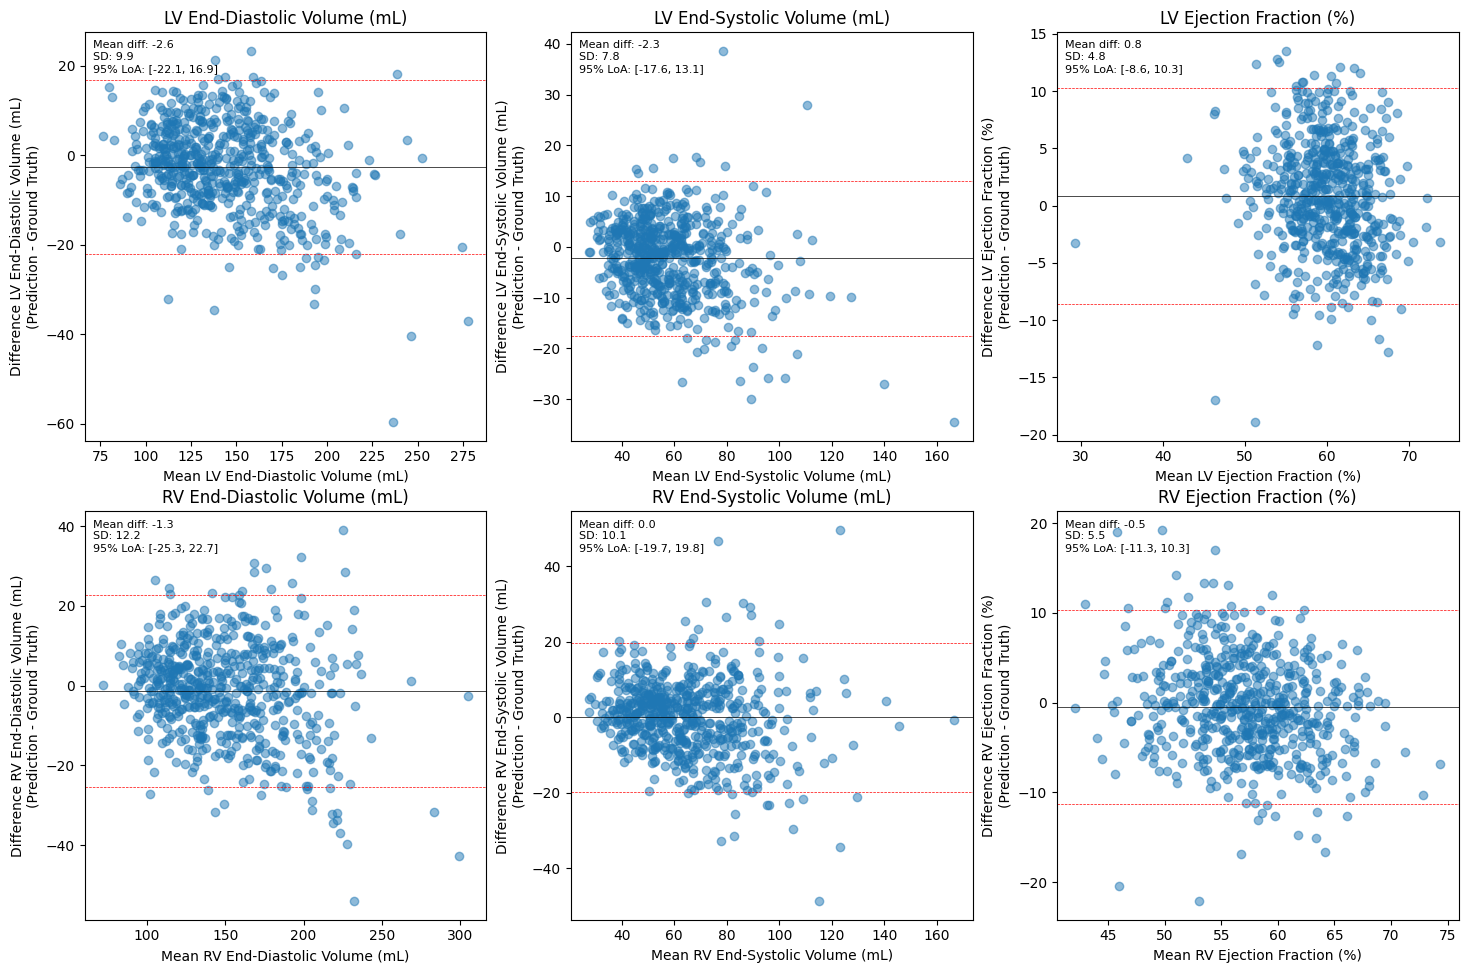

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def bland_altman_plot(data1, data2, title, parameter_name, ax=None):
    # Convert to numeric and remove any NaN values
    data1 = pd.to_numeric(data1, errors='coerce')
    data2 = pd.to_numeric(data2, errors='coerce')
    
    # Remove NaN values
    mask = ~(np.isnan(data1) | np.isnan(data2))
    data1 = data1[mask]
    data2 = data2[mask]
    
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff, axis=0)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot scatter and lines
    ax.scatter(mean, diff, alpha=0.5)
    ax.axhline(md, color='k', linestyle='-', linewidth=0.5)
    ax.axhline(md + 1.96*sd, color='r', linestyle='--', linewidth=0.5)
    ax.axhline(md - 1.96*sd, color='r', linestyle='--', linewidth=0.5)
    
    # Add labels
    ax.set_xlabel(f'Mean {parameter_name}')
    ax.set_ylabel(f'Difference {parameter_name}\n(Prediction - Ground Truth)')
    ax.set_title(title)
    
    # Add text for statistics
    stats_text = f'Mean diff: {md:.1f}\nSD: {sd:.1f}\n95% LoA: [{md - 1.96*sd:.1f}, {md + 1.96*sd:.1f}]'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=8)
    
    return ax

# Create figure with subplots for all parameters
def create_bland_altman_plots(pred_df, true_df):
    parameters = [
        ('LVEDV', 'LV End-Diastolic Volume (mL)'),
        ('LVESV', 'LV End-Systolic Volume (mL)'),
        ('LVEF', 'LV Ejection Fraction (%)'),
        ('RVEDV', 'RV End-Diastolic Volume (mL)'),
        ('RVESV', 'RV End-Systolic Volume (mL)'),
        ('RVEF', 'RV Ejection Fraction (%)')
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    plt.tight_layout(pad=3.0)
    
    for (param, title), ax in zip(parameters, axes.flat):
        bland_altman_plot(
            pred_df[param],
            true_df[param],
            f'{title}',
            title,
            ax=ax
        )
    
    return fig

# Load your data with appropriate data types
pred_df = pd.read_csv('../CardiacIndexes/LVRV_ours.csv',
                      names=['pid', 'LVEDV', 'LVESV', 'LVSV', 'LVEF', 'LVM', 
                            'RVEDV', 'RVESV', 'RVSV', 'RVEF'])

true_df = pd.read_csv('../CardiacIndexes/LVRV_GT.csv',
                      names=['pid', 'LVEDV', 'LVESV', 'LVSV', 'LVEF', 'LVM', 
                            'RVEDV', 'RVESV', 'RVSV', 'RVEF'])

# Create and save plots
fig = create_bland_altman_plots(pred_df, true_df)
plt.savefig('bland_altman_plots.pdf', bbox_inches='tight', dpi=300)

# Print summary statistics
parameters = ['LVEDV', 'LVESV', 'LVEF', 'RVEDV', 'RVESV', 'RVEF']
print("\nSummary Statistics:")
print("Parameter | Mean Difference ± SD | 95% Limits of Agreement")
print("-" * 60)

for param in parameters:
    pred_values = pd.to_numeric(pred_df[param], errors='coerce')
    true_values = pd.to_numeric(true_df[param], errors='coerce')
    
    # Remove NaN values
    mask = ~(np.isnan(pred_values) | np.isnan(true_values))
    diff = pred_values[mask] - true_values[mask]
    
    md = np.mean(diff)
    sd = np.std(diff)
    loa_lower = md - 1.96 * sd
    loa_upper = md + 1.96 * sd
    print(f"{param:8} | {md:6.1f} ± {sd:5.1f} | [{loa_lower:6.1f}, {loa_upper:6.1f}]")

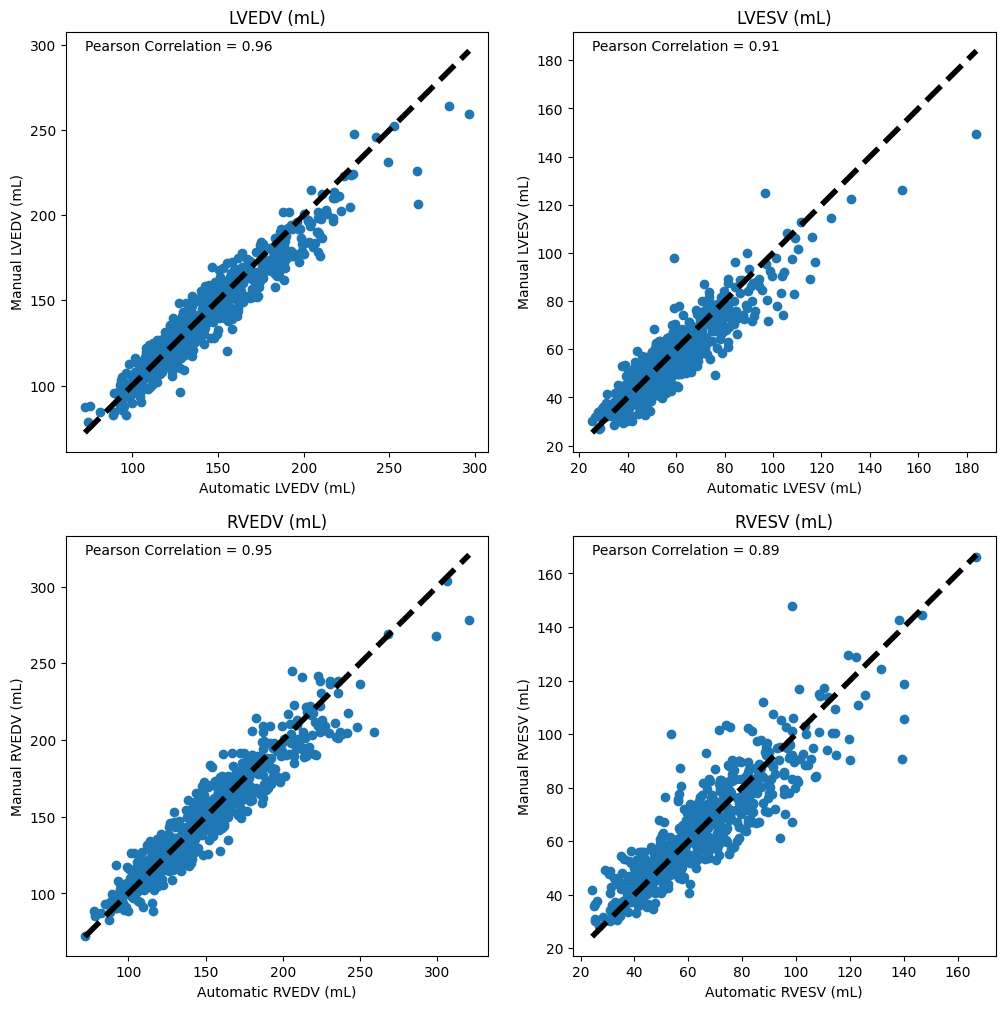

In [5]:
from scipy.stats import pearsonr
import numpy as np

df1 = pd.read_csv('../CardiacIndexes/LVRV_ours.csv')
df2 = pd.read_csv('../CardiacIndexes/LVRV_GT.csv')

metrics = ['LVEDV (mL)', 'LVESV (mL)', 'RVEDV (mL)', 'RVESV (mL)']

import matplotlib.pyplot as plt 

plt.figure(figsize = (12, 12))

for i in range(0, 4):
    ax = plt.subplot(2, 2, 1 + i)
    y_gt = df2[metrics[i]].to_numpy()
    y_pred = df1[metrics[i]].to_numpy()
    
    plt.scatter(y_gt, y_pred)
    plt.ylabel("Manual " + metrics[i])
    plt.xlabel("Automatic " + metrics[i])
    
    ax.plot([y_gt.min(), y_gt.max()], [y_gt.min(), y_gt.max()], 'k--', lw=4)
    ax.annotate("Pearson Correlation = {:.2f}".format(pearsonr(y_gt, y_pred)[0]), (y_gt.min(), y_gt.max()))
    
    #a, b = np.polyfit(y_pred, y_gt, 1)
    #ax.annotate("y = %.2f x + %.2f"%(a,b), (0.7 * y_gt.max(), y_gt.min()))
    
    plt.title(metrics[i])
    

In [7]:

def get_nice_dataframe(df, metrics, vertical = False):
    models = df["Model"].unique()

    # creates a dataframe where each metric has a column for its mean and std.
    # the mean and std. are computed for each model
    # the dataframe is then saved as a csv file
    df_std = pd.DataFrame(columns=metrics)
    for metric in metrics:
        df_std[metric] = df.groupby(["Model"])[metric].std()

    df_mean = pd.DataFrame(columns=metrics)
    for metric in metrics:
        df_mean[metric] = df.groupby(["Model"])[metric].mean()

    df_mean = df_mean.round(0)
    df_std = df_std.round(0)

    #combine both dataframes, intercalating columns

    empty_df = pd.DataFrame(columns = metrics)
    for metric in metrics:
        i = 0
        for model in models:
            mean_str = str(df_mean.loc[model, metric]).split('.')[0]
            std_str = str(df_std.loc[model, metric]).split('.')[0]
            #if len(mean_str) == 3 or (mean_str[2] == '.' and len(mean_str) == 4):
            #    mean_str += '0'
            #if len(std_str) == 3 or (std_str[2] == '.' and len(std_str) == 4):
            #    std_str += '0'
              
            empty_df.loc[model, metric] = mean_str + " (" + std_str + ")"
            i+=1

    # transposes the dataframe
    if vertical:
        empty_df = empty_df.T
    
    return empty_df

metrics =  ['LVEDV (mL)', 'LVESV (mL)', 'LVSV (mL)', 'LVEF (%)', 'LVM (g)', 
            'RVEDV (mL)', 'RVESV (mL)', 'RVSV (mL)', 'RVEF (%)']

df1["Model"] = "Ours"
df2["Model"] = "GT"

get_nice_dataframe(pd.concat([df2, df1]), metrics, vertical = True)

,GT,Ours
LVEDV (mL),145 (34),142 (31)
LVESV (mL),59 (18),57 (16)
LVSV (mL),85 (19),85 (18)
LVEF (%),59 (5),60 (5)
LVM (g),88 (25),86 (22)
RVEDV (mL),150 (39),149 (36)
RVESV (mL),65 (22),65 (20)
RVSV (mL),85 (21),84 (19)
RVEF (%),57 (6),57 (5)


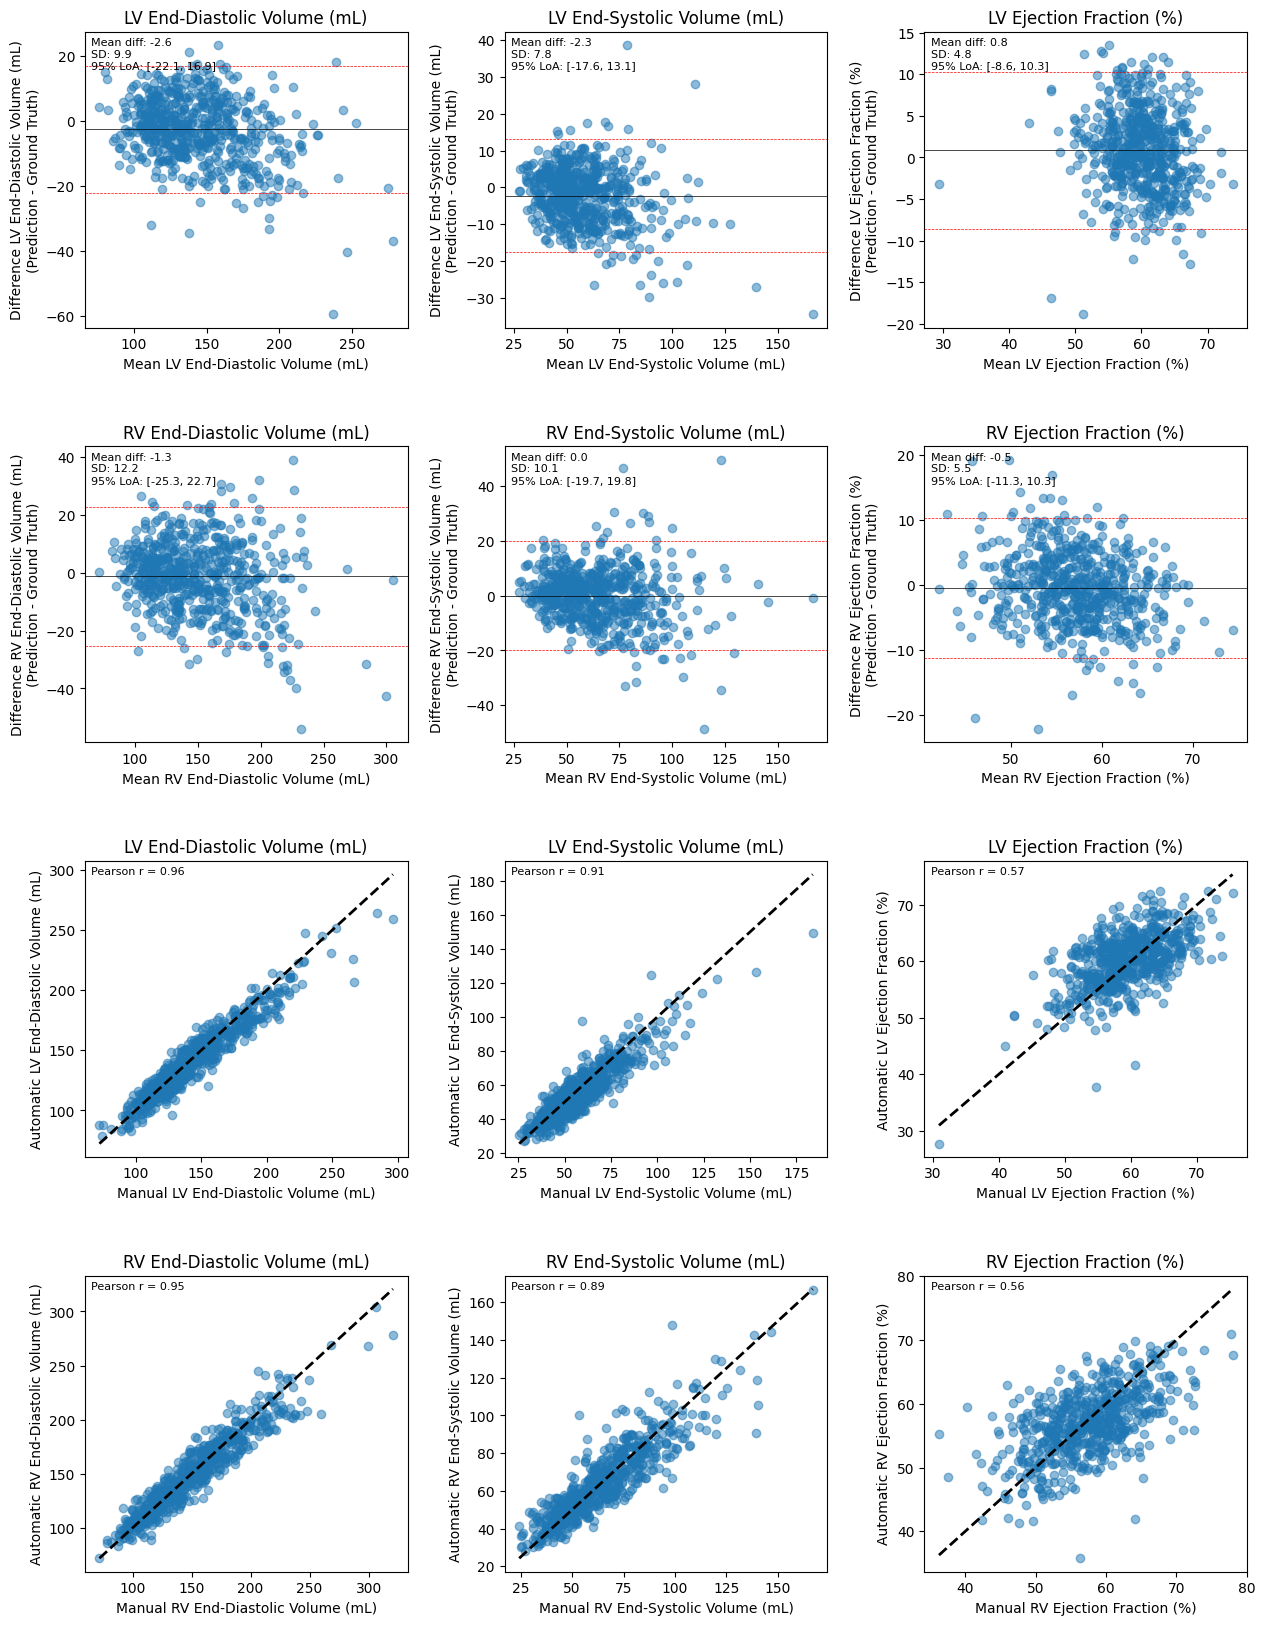

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

def bland_altman_plot(data1, data2, title, parameter_name, ax=None):
    # Convert to numeric and remove any NaN values
    data1 = pd.to_numeric(data1, errors='coerce')
    data2 = pd.to_numeric(data2, errors='coerce')
    
    # Remove NaN values
    mask = ~(np.isnan(data1) | np.isnan(data2))
    data1 = data1[mask]
    data2 = data2[mask]
    
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff, axis=0)
    
    # Plot scatter and lines
    ax.scatter(mean, diff, alpha=0.5)
    ax.axhline(md, color='k', linestyle='-', linewidth=0.5)
    ax.axhline(md + 1.96*sd, color='r', linestyle='--', linewidth=0.5)
    ax.axhline(md - 1.96*sd, color='r', linestyle='--', linewidth=0.5)
    
    # Add labels
    ax.set_xlabel(f'Mean {parameter_name}')
    ax.set_ylabel(f'Difference {parameter_name}\n(Prediction - Ground Truth)')
    ax.set_title(f'{title}')
    
    # Add text for statistics
    stats_text = f'Mean diff: {md:.1f}\nSD: {sd:.1f}\n95% LoA: [{md - 1.96*sd:.1f}, {md + 1.96*sd:.1f}]'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=8)

def correlation_plot(data1, data2, title, parameter_name, ax=None):
    # Convert to numeric and remove any NaN values
    data1 = pd.to_numeric(data1, errors='coerce')
    data2 = pd.to_numeric(data2, errors='coerce')
    
    # Remove NaN values
    mask = ~(np.isnan(data1) | np.isnan(data2))
    data1 = data1[mask]
    data2 = data2[mask]
    
    # Plot scatter and identity line
    ax.scatter(data2, data1, alpha=0.5)
    ax.plot([data2.min(), data2.max()], [data2.min(), data2.max()], 'k--', lw=2)
    
    # Calculate and add correlation coefficient
    corr, _ = pearsonr(data2, data1)
    ax.text(0.02, 0.98, f'Pearson r = {corr:.2f}', transform=ax.transAxes,
            verticalalignment='top', fontsize=8)
    
    # Add labels
    ax.set_xlabel(f'Manual {parameter_name}')
    ax.set_ylabel(f'Automatic {parameter_name}')
    ax.set_title(f'{title}')

def create_combined_plots(pred_df, true_df):
    parameters = [
        ('LVEDV', 'LV End-Diastolic Volume (mL)'),
        ('LVESV', 'LV End-Systolic Volume (mL)'),
        ('LVEF', 'LV Ejection Fraction (%)'),
        ('RVEDV', 'RV End-Diastolic Volume (mL)'),
        ('RVESV', 'RV End-Systolic Volume (mL)'),
        ('RVEF', 'RV Ejection Fraction (%)')
    ]
    
    # Create 4x3 subplot grid
    fig = plt.figure(figsize=(15, 20))
    gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)
    
    # Create plots for each parameter
    for i, (param, title) in enumerate(parameters):
        # Bland-Altman plot
        ax_ba = fig.add_subplot(gs[i//3, i%3])
        bland_altman_plot(pred_df[param], true_df[param], title, title, ax=ax_ba)
        
        # Correlation plot
        ax_corr = fig.add_subplot(gs[(i//3)+2, i%3])
        correlation_plot(pred_df[param], true_df[param], title, title, ax=ax_corr)
    
    return fig

# Load your data
pred_df = pd.read_csv('../CardiacIndexes/LVRV_ours.csv',
                      names=['pid', 'LVEDV', 'LVESV', 'LVSV', 'LVEF', 'LVM',
                            'RVEDV', 'RVESV', 'RVSV', 'RVEF'])
true_df = pd.read_csv('../CardiacIndexes/LVRV_GT.csv',
                      names=['pid', 'LVEDV', 'LVESV', 'LVSV', 'LVEF', 'LVM',
                            'RVEDV', 'RVESV', 'RVSV', 'RVEF'])

# Create and save plots
fig = create_combined_plots(pred_df, true_df)
plt.savefig('ToPlot/combined_analysis_plots.pdf', bbox_inches='tight', dpi=300)

In [4]:
def calculate_statistics(pred_df, true_df):
    """
    Calculate comprehensive statistics for each parameter including:
    - Bland-Altman metrics (bias, SD, limits of agreement)
    - Correlation coefficients
    - Mean absolute error (MAE)
    - Root mean square error (RMSE)
    - Relative percentage errors
    """
    parameters = [
        ('LVEDV', 'LV End-Diastolic Volume'),
        ('LVESV', 'LV End-Systolic Volume'),
        ('LVEF', 'LV Ejection Fraction'),
        ('RVEDV', 'RV End-Diastolic Volume'),
        ('RVESV', 'RV End-Systolic Volume'),
        ('RVEF', 'RV Ejection Fraction')
    ]
    
    print("\nComprehensive Statistical Analysis:")
    print("=" * 100)
    
    for param, param_name in parameters:
        # Convert to numeric and handle NaN values
        pred_values = pd.to_numeric(pred_df[param], errors='coerce')
        true_values = pd.to_numeric(true_df[param], errors='coerce')
        mask = ~(np.isnan(pred_values) | np.isnan(true_values))
        pred_values = pred_values[mask]
        true_values = true_values[mask]
        
        # Calculate differences for Bland-Altman
        diff = pred_values - true_values
        mean_diff = np.mean(diff)
        sd_diff = np.std(diff)
        loa_lower = mean_diff - 1.96 * sd_diff
        loa_upper = mean_diff + 1.96 * sd_diff
        
        # Calculate correlation coefficient
        corr, p_value = pearsonr(true_values, pred_values)
        
        # Calculate error metrics
        mae = np.mean(np.abs(diff))
        rmse = np.sqrt(np.mean(np.square(diff)))
        
        # Calculate relative errors
        rel_error = np.abs(diff / true_values) * 100
        mean_rel_error = np.mean(rel_error)
        
        # Print results
        print(f"\n{param_name} ({param}):")
        print("-" * 50)
        print(f"Bland-Altman Analysis:")
        print(f"  Bias (mean difference): {mean_diff:.2f}")
        print(f"  Standard Deviation: {sd_diff:.2f}")
        print(f"  95% Limits of Agreement: [{loa_lower:.2f}, {loa_upper:.2f}]")
        print(f"\nCorrelation Analysis:")
        print(f"  Pearson Correlation Coefficient: {corr:.3f}")
        print(f"  P-value: {p_value:.3e}")
        print(f"\nError Metrics:")
        print(f"  Mean Absolute Error (MAE): {mae:.2f}")
        print(f"  Root Mean Square Error (RMSE): {rmse:.2f}")
        print(f"  Mean Relative Error: {mean_rel_error:.2f}%")
        
        # Calculate and print additional statistics
        print(f"\nDescriptive Statistics:")
        print(f"  Ground Truth - Mean: {np.mean(true_values):.2f}, SD: {np.std(true_values):.2f}")
        print(f"  Prediction  - Mean: {np.mean(pred_values):.2f}, SD: {np.std(pred_values):.2f}")

# Example usage
calculate_statistics(pred_df, true_df)


Comprehensive Statistical Analysis:

LV End-Diastolic Volume (LVEDV):
--------------------------------------------------
Bland-Altman Analysis:
  Bias (mean difference): -2.62
  Standard Deviation: 9.94
  95% Limits of Agreement: [-22.10, 16.87]

Correlation Analysis:
  Pearson Correlation Coefficient: 0.957
  P-value: 0.000e+00

Error Metrics:
  Mean Absolute Error (MAE): 7.92
  Root Mean Square Error (RMSE): 10.28
  Mean Relative Error: 5.42%

Descriptive Statistics:
  Ground Truth - Mean: 144.54, SD: 33.98
  Prediction  - Mean: 141.92, SD: 30.96

LV End-Systolic Volume (LVESV):
--------------------------------------------------
Bland-Altman Analysis:
  Bias (mean difference): -2.28
  Standard Deviation: 7.83
  95% Limits of Agreement: [-17.62, 13.05]

Correlation Analysis:
  Pearson Correlation Coefficient: 0.905
  P-value: 1.793e-224

Error Metrics:
  Mean Absolute Error (MAE): 6.21
  Root Mean Square Error (RMSE): 8.15
  Mean Relative Error: 10.49%

Descriptive Statistics:
  Grou